In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torch.utils.data import DataLoader
from datasets import load_dataset

import timm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report


/Users/bhara-zstch1566/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
cnt = 0
# path = "/Users/bhara-zstch1566/Projects/CRM DI/Document Type Detection/Dataset"
# for i in os.listdir(path):
#     if i[0]==".":
#         continue
#     print(len(os.listdir(path+"/"+i)),i)


In [3]:
dataset = load_dataset("bharath-shanmugasundaram/Document-Type-Detection")

print(dataset)


Resolving data files:   0%|          | 0/51 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/51 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/18 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 40000
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


In [4]:
class_names = dataset["train"].features["label"].names
num_classes = len(class_names)

print(class_names)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def transform_fn(example):
    images = example["image"]

    if isinstance(images, list):
        example["image"] = [
            transform(img.convert("RGB")) for img in images
        ]
    else:
        example["image"] = transform(images.convert("RGB"))

    return example


dataset = dataset.with_transform(transform_fn)


['Bank Statement', 'Government Forms', 'Insurence', 'Invoice', 'Resume']


In [ ]:
train_loader = DataLoader(dataset["train"],batch_size=64,shuffle=True,num_workers=12,pin_memory=True,persistent_workers=True,prefetch_factor=4,drop_last=True)

val_loader = DataLoader(dataset["validation"],batch_size=64,shuffle=True,num_workers=12,pin_memory=True,persistent_workers=True,prefetch_factor=4,drop_last=True)


In [ ]:
model = timm.create_model("swin_base_patch4_window7_224",pretrained=True,num_classes=num_classes)

for param in model.parameters():
    param.requires_grad = False

for param in model.head.parameters():
    param.requires_grad = True

for param in model.layers[-1].parameters():
    param.requires_grad = True



In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW([{"params": model.layers[-1].parameters(), "lr": 1e-4},{"params": model.head.parameters(), "lr": 1e-3},])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cuda


In [ ]:
EPOCHS = 6

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for batch in train_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    print("training",epoch)

    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for batch in val_loader:
            images = batch["image"].to(device)
            labels = batch["label"].to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = (correct/total) *100

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.2f}%")


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/PIL/Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


training 0
Epoch [1/6] | Train Loss: 0.4991 | Val Acc: 86.97%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/PIL/Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


training 1
Epoch [2/6] | Train Loss: 0.3314 | Val Acc: 89.05%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/PIL/Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


training 2
Epoch [3/6] | Train Loss: 0.2552 | Val Acc: 89.98%
training 3
Epoch [4/6] | Train Loss: 0.1980 | Val Acc: 90.17%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/PIL/Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


training 4
Epoch [5/6] | Train Loss: 0.1551 | Val Acc: 90.82%


/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/PIL/Image.py:1034: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


training 5
Epoch [6/6] | Train Loss: 0.1231 | Val Acc: 90.23%


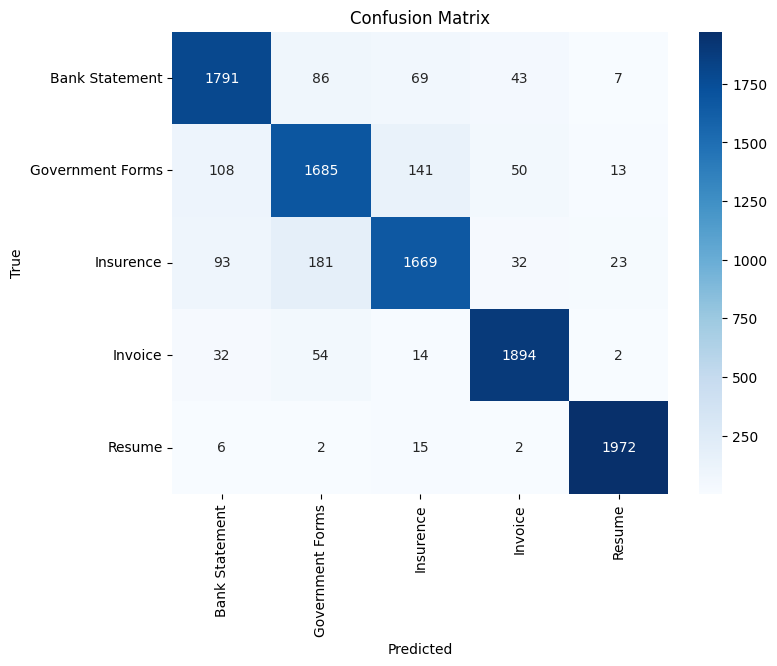

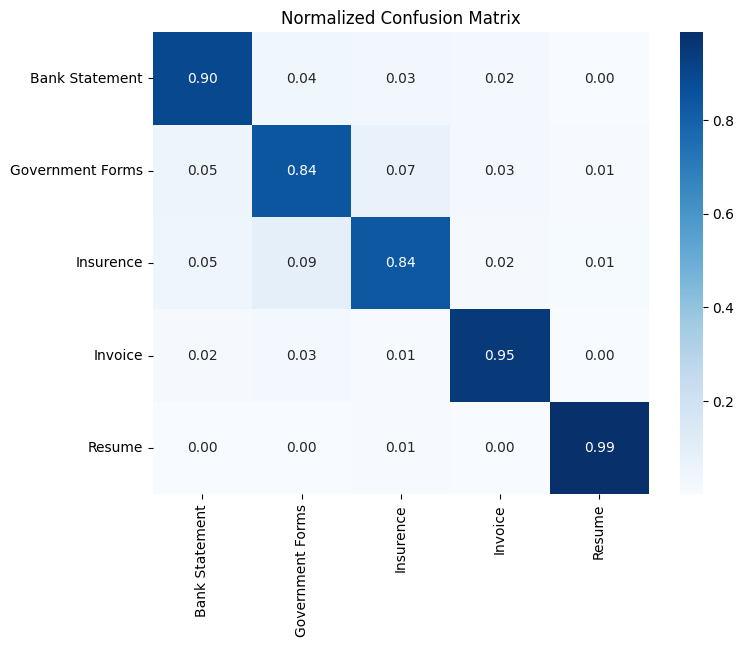

Classification Report:

                  precision    recall  f1-score   support

  Bank Statement       0.88      0.90      0.89      1996
Government Forms       0.84      0.84      0.84      1997
       Insurence       0.87      0.84      0.85      1998
         Invoice       0.94      0.95      0.94      1996
          Resume       0.98      0.99      0.98      1997

        accuracy                           0.90      9984
       macro avg       0.90      0.90      0.90      9984
    weighted avg       0.90      0.90      0.90      9984



In [9]:
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title("Normalized Confusion Matrix")
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


In [10]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "num_classes": 5,
    "model_name": "swin_base_patch4_window7_224"
}, "model1.pth")


In [11]:
model.eval()
correct = 0
total = 0
print("test")
with torch.no_grad():
    for batch in val_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_acc = 100 * correct / total

print(
    f"Epoch [{epoch+1}/5] | "
    f"Train Loss: {train_loss:.4f} | "
    f"Test Acc: {test_acc:.2f}%"
)


test
Epoch [6/5] | Train Loss: 0.1231 | Test Acc: 90.22%
